TODO:
1. **get additional info (e.g. names of committees)**
2. lemmatize? [[1](https://github.com/synhershko/HebMorph),[2](https://docs.hebrew-nlp.co.il/#/Morph/Normalize)]
3. **remove non-informative words** (especially if using clustering rather than classification)
5. look for word embedding [[1](https://github.com/NLPH/NLPH_Resources#embeddings),[2](https://github.com/liorshk/wordembedding-hebrew)]
6. understand deep LDA from [reference](https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05) (possibly different embedding); go over [gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
7. use other features in addition to words counters (e.g. length, english words, numbers, etc.)
8. **only parse "important" sections (e.g. intro & summary)**
9. detect entities to increase weight of corresponding tokens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import random
from pathlib import Path
from time import time
from datetime import datetime
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
from warnings import warn
from datetime import datetime
import itertools
from collections import Counter, OrderedDict
from bidi import algorithm as bidi
from hebrew_stopwords import hebrew_stopwords

In [3]:
mpl.rcParams.update({'font.size': 13})

# Load data

In [4]:
%%time
DATA = Path('Data')
meta = pd.read_csv(DATA/'meta.csv')
df = pd.read_csv(DATA/'data.csv')

Wall time: 34.7 s


In [5]:
if len(meta)!=len(np.unique(df.ID)):
    warn(f'Inconsistent dimensions! {len(meta):d}!={len(np.unique(df.ID)):d}')

# Parser

In [6]:
from Parser import Parser, show_freqs, ordered_counter, EXTRA_STOPWORDS

In [7]:
%time p = Parser(df, meta)

100%|██████████████████████████████████████████████████████████████████████| 6760339/6760339 [20:54<00:00, 5388.01it/s]


Vocabulary: 1000'th word => 26232 occurences.
Vocabulary: 10 occurences => 245431 words.


37177it [23:44, 18.52it/s]


Wall time: 47min 13s


# EDA

C:\Users\idogr\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


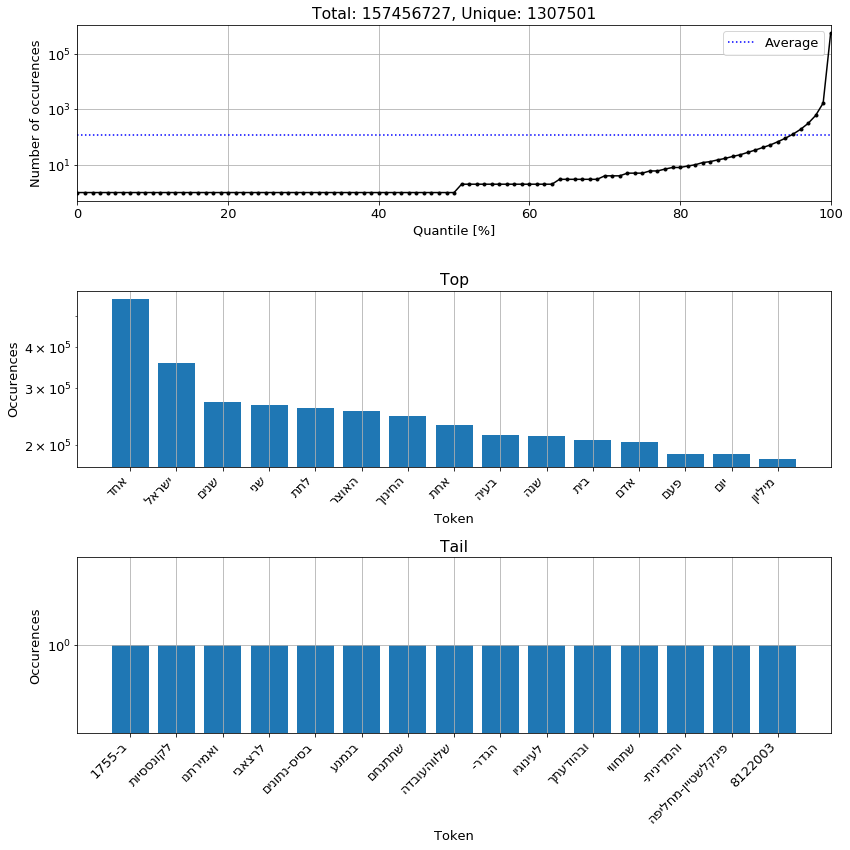

In [8]:
p.show_tokens()

In [13]:
p.profile if p.profile else ordered_counter(p.tokens)

OrderedDict([('אחד', 562971),
             ('ישראל', 356691),
             ('שנים', 271622),
             ('שני', 266047),
             ('לתת', 259782),
             ('האוצר', 253879),
             ('החינוך', 245784),
             ('אחת', 230769),
             ('בעיה', 214982),
             ('שנה', 213232),
             ('בית', 207470),
             ('אדם', 204154),
             ('פעם', 187973),
             ('יום', 187824),
             ('מיליון', 181696),
             ('מספר', 159384),
             ('רשות', 157991),
             ('העבודה', 154181),
             ('השאלה', 154086),
             ('שקל', 153339),
             ('דיון', 153286),
             ('הבעיה', 151445),
             ('שקלים', 150341),
             ('זמן', 146352),
             ('עובדים', 143351),
             ('כסף', 142957),
             ('מקום', 142212),
             ('עבודה', 142185),
             ('המשפט', 140380),
             ('מציע', 138851),
             ('ברור', 138609),
             ('השר', 138293),
      

#### Encoding and PCA

In [9]:
p.one_hot.head()

,1,10,100,12,15,2,20,3,30,4,...,תלמידים,תמיד,תנאי,תקופה,תקופת,תקנה,תקנות,תקציב,תשובה,תשלום
0,4,4,0,0,0,6,4,4,2,2,...,0,6,0,0,2,0,0,1,1,0
1,4,0,0,0,0,0,0,0,0,3,...,0,1,1,0,0,0,0,4,5,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2,2,0,0,0,2,0,2,0,0,...,0,1,0,0,0,0,0,2,0,1
4,3,0,0,0,0,2,0,0,1,2,...,0,0,1,0,0,0,1,0,0,2


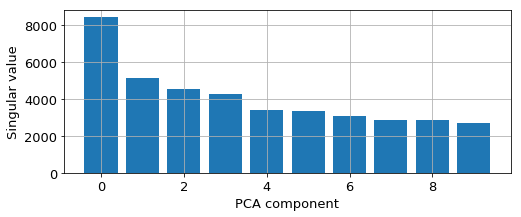

In [10]:
from sklearn.decomposition import PCA
n_comps = 10
pca = PCA(n_components=n_comps)
pca.fit(p.one_hot)
plt.figure(figsize=(8,3))
plt.bar(list(range(n_comps)), pca.singular_values_)
plt.xlabel('PCA component')
plt.ylabel('Singular value')
plt.grid()
X2D = np.matmul(p.one_hot.as_matrix(), pca.components_[:2,:].transpose())
X3D = np.matmul(p.one_hot.as_matrix(), pca.components_[:3,:].transpose())

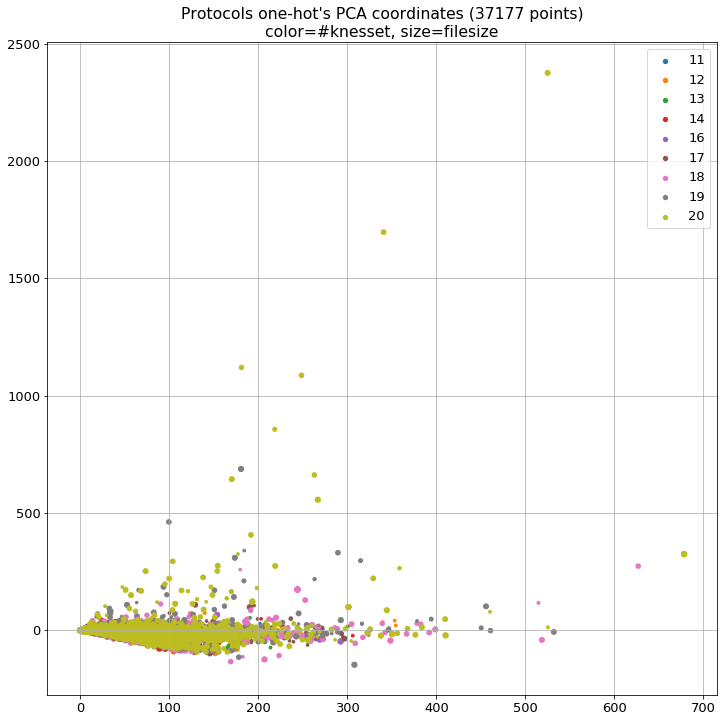

In [11]:
_, ax = plt.subplots(1,1, figsize=(12,12))

for grp in np.unique(meta[meta.ID.isin(df.ID)].KnessetNum): # TODO color by committee name rather than KnessetNum once available
    X = X2D[np.where(meta[meta.ID.isin(df.ID)].KnessetNum==grp),:].reshape(-1,2)
    sc = ax.scatter(X[:,0], X[:,1], s=np.log10(meta[meta.ID.isin(df.ID)].filesize)**2, label=int(grp))
    
ax.set_title(f"Protocols one-hot's PCA coordinates ({X2D.shape[0]:d} points)\ncolor=#knesset, size=filesize")
ax.grid()
ax.legend()

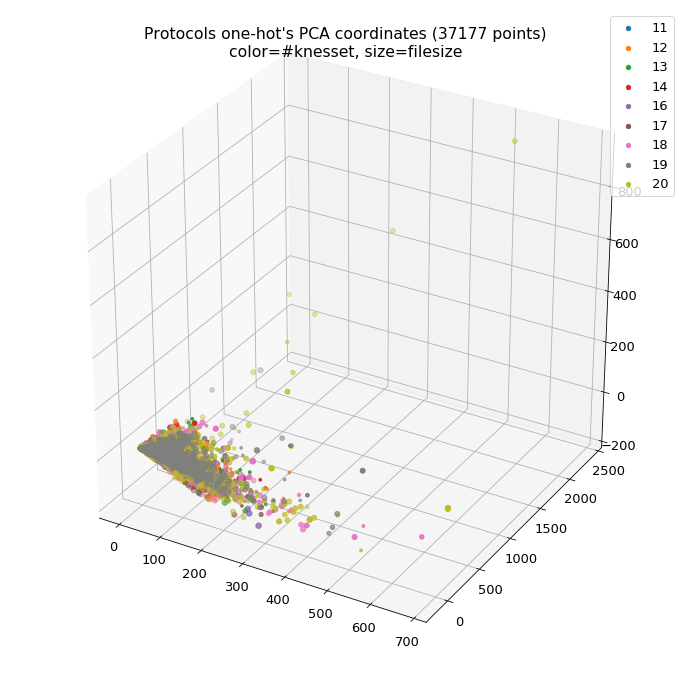

In [12]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection='3d')

for grp in np.unique(meta[meta.ID.isin(df.ID)].KnessetNum):
    X = X3D[np.where(meta[meta.ID.isin(df.ID)].KnessetNum==grp),:].reshape(-1,3)
    ax.scatter(X[:,0],X[:,1],X[:,2], label=int(grp),
               s=np.log10(meta[meta.ID.isin(df.ID)].filesize)**2)#, c=meta[meta.ID.isin(df.ID)].KnessetNum)
    
ax.set_title(f"Protocols one-hot's PCA coordinates ({X3D.shape[0]:d} points)\ncolor=#knesset, size=filesize")
ax.grid()
ax.legend()

#### Print some random protocols

In [14]:
print(p.full_protocol())

________
:
הכנסת העשרים

מושב שלישי

פרוטוקול מס' 156

מישיבת הוועדה לזכויות הילד

יום שלישי, י"ט בסיון התשע"ז (13 ביוני 2017), שעה 10:00

________
סדר היום:
סיור בקמפוס חרוב לילדים

________
נכחו:


________
חברי הוועדה::
יפעת שאשא ביטון – היו"ר

________
מוזמנים::
דליה לב שדה - מנהלת שירות ילד ונוער, משרד העבודה, הרווחה והשירותים החברתיים

איזבל סרי לוי - מפקחת ארצית פגיעות מיניות, משרד העבודה, הרווחה והשירותים החברתיים

חוה לוי - עובדת סוציאלית ראשית לחוק נוער, משרד העבודה, הרווחה והשירותים החברתיים

רינת וייגלר - עורכת דין, לשכה משפטית, משרד העבודה, הרווחה והשירותים החברתיים

שוש תורג'מן - מנהלת "בית לין", מרכז הגנה לילדים ונוער, משרד העבודה, הרווחה והשירותים החברתיים

רחל דניאלי - עורכת דין, ממונה ארצית על ייצוג נוער, הסניגוריה הציבורית, משרד המשפטים

ד"ר איריס לייטרסדורף - מנהלת המחלקה לבקרה על קופות החולים, מינהל רפואה, משרד הבריאות

מירב סבן - מנהלת מיטל, המרכז לטיפול בילדים ובני נוער נפגעי תקיפה מינית, משרד העבודה, הרווחה והשירותים החברתיים

אושרת שוהם - עורכת דין, פרקליטות מח

הישיבה ננעלה בשעה 12:00.


In [15]:
print(p.full_protocol())

________
:
הכנסת התשע-עשרה

נוסח לא מתוקן

מושב ראשון

פרוטוקול מס' 112

מישיבת ועדת הכספים

יום שלישי, ב' באב התשע"ג (09 ביולי 2013), שעה 10:30

________
סדר היום:
הצעת חוק התקציב לשנות הכספים 2013 ו-2014, התשע"ג-2013

________
נכחו:


________
חברי הוועדה::
ניסן סלומינסקי – היו"ר

רוברט אילטוב

קארין אלהרר

מיכל בירן

זהבה גלאון

גילה גמליאל

משה גפני

בועז טופורובסקי

אחמד טיבי

יצחק כהן

עליזה לביא

יעקב ליצמן

עמרם מצנע

אראל מרגלית

משולם נהרי

אורית סטרוק

חמד עמאר

עיסאווי פריג'

אברהים צרצור

זבולון קלפה

ראובן ריבלין

אלעזר שטרן

עפר שלח

סתיו שפיר

איילת שקד

________
מוזמנים::
שר הפנים גדעון סער

יגאל צרפתי - מנכ"ל משרד הפנים, משרד הפנים

אמנון בן עמי - מנכ"ל רשות האוכלוסין, משרד הפנים

יהודה זמרת - היועץ המשפטי, משרד הפנים

בינת שוורץ - מנהלת מינהל התכנון, משרד הפנים

מרדכי כהן - מנהל המינהל לשלטון מקומי, משרד הפנים

סיון להבי - מנהל תחום בקרה תקצוב ופיתוח, משרד הפנים

לילי פיינטוך - מנהלת אגף בכיר לבקרה תקצוב ופיתוח ברשומ', משרד הפנים

ליאת פרוינד - לשכה משפטית, משרד הפני

הישיבה ננעלה בשעה 12:48.


In [16]:
print(p.full_protocol())

________
:
äëðñú äùáò-òùøä

äëðñú äùáò-òùøä

com_alex

2008-05-28Liraz



הכנסת השבע-עשרה נוסח לא מתוקן

מושב שלישי

פרוטוקול מס' 127

מישיבת הוועדה לקידום מעמד האישה

יום שני, ז' באייר התשס"ח (12 במאי 2008), שעה 10:30

________
סדר היום: דיווח על יישום תוכניות:
תוכנית לטיפול בנפגעי תקיפה מינית

תוכנית טיפול להוצאת נשים ממעגל הזנות

________
נכחו:


________
חברי הוועדה:
ליה שמטוב – היו"ר

קולט אביטל

זהבה גלאון

יואל חסון

שי חרמש

שלמה נגוסה מולה

מיכאל נודלמן

אורית נוקד

גדעון סער

משה שרוני

________
מוזמנים:
ראש הממשלה אהוד אולמרט

עו"ד צחי גבריאלי - עוזר אישי לראש הממשלה

נחום איצקוביץ - מנכ"ל משרד הרווחה והשירותים החברתיים

מנחם וגשל - משנה למנכ"ל משרד הרווחה והשירותים החברתיים

עדה פליאל טרוסמן - ממונה על הטיפול בנשים, משרד הרווחה והשירותים החברתיים

עפרה לביאן - יועצת בכירה למנכ"ל משרד הרווחה והשירותים החברתיים

ציפי נחשון גליק - מפקחת ארצית לטיפול באלימות במשפחה

עדה פליאל טרוסמן - ממונה על הטיפול בנשים

נואל אבו חאטום - מפקחת בשירות לטיפול בנערות צעירות

ציפי לפלר - מנהלת מ

הישיבה ננעלה בשעה 12:05.


In [17]:
print(p.full_protocol())

________
:
הכנסת העשרים

מושב שלישי

פרוטוקול מס' 21

מישיבת הוועדה המשותפת לוועדת החוקה, חוק ומשפט, לוועדת הפנים והגנת הסביבה ולוועדת המדע והטכנולוגיה

בהתאם לחוק הכללת אמצעי זיהוי ביומטריים ונתוני זיהוי ביומטריים במסמכי זיכוי ובמאגרי מידע התש"ע-2009

יום רביעי, כ"ד באדר התשע"ז (22 במרץ 2017), שעה 9:00

________
סדר היום:
תקנות הכללת אמצעי זיהוי ביומטריים ונתוני זיהוי ביומטריים במסמכי זיהוי ובמאגר מידע (תיקון והוראת שעה), התשע"ז-2017

________
נכחו:


________
חברי הוועדה::
אורי מקלב – היו"ר

תמר זנדברג

דב חנין

אכרם חסון

חיים ילין

מיכאל מלכיאלי

________
חברי הכנסת:
יעל כהן-פארן

יוליה מלינובסקי

________
מוזמנים::
ממונה בכירה, מח' ייעוץ וחקיקה, משרד המשפטים  - אביטל שטרנברג

מתמחה, משרד המשפטים  - גילת בן שחר

מח' ייעוץ וחקיקה, משרד המשפטים  - מיכל אברהם

מח' יעוץ וחקיקה, משרד המשפטים  - ליאת יעקובוביץ

היועץ המשפטי, רשות הסייבר הלאומית, משרד ראש הממשלה  - עמית אשכנזי

יועצת משפטית, משרד ראש הממשלה  - נעמה בן- צבי

ראש אגף תמ"ק, משרד ראש הממשלה  - אליהו גזית

ראש מטה שר הפנים, מש

הישיבה ננעלה בשעה 11:30.
